In [157]:
##必要なライブラリのインポート
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import xgboost as xgb

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [158]:
#データの読み込み
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

#combineを作ることで学習用データとテストデータを同時に整形する
combine = [train_df, test_df]


In [159]:
all_data = pd.concat((train_df.loc[:, 'MSSubClass':'SaleCondition'],test_df.loc[:, 'MSSubClass':'SaleCondition']))

In [160]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [161]:
dropf = missing_data.loc[missing_data['Total']==1].index

In [162]:
all_data.loc[all_data['Electrical'].isnull(),'Electrical'] 

1379    NaN
Name: Electrical, dtype: object

In [163]:
all_data[dropf].describe()

,BsmtFinSF2,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageArea,GarageCars
count,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000
mean,49.582248,441.423235,560.772104,1051.777587,472.874572,1.766621
std,169.205611,455.610826,439.543659,440.766258,215.394815,0.761624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,220.000000,793.000000,320.000000,1.000000
50%,0.000000,368.500000,467.000000,989.500000,480.000000,2.000000
75%,0.000000,733.000000,805.500000,1302.000000,576.000000,2.000000
max,1526.000000,5644.000000,2336.000000,6110.000000,1488.000000,5.000000


In [164]:
all_data[dropf].describe(include='O')

,Exterior2nd,Exterior1st,SaleType,Electrical,KitchenQual
count,2918,2918,2918,2918,2918
unique,16,15,9,5,4
top,VinylSd,VinylSd,WD,SBrkr,TA
freq,1014,1025,2525,2671,1492


In [165]:
all_data = all_data.drop((missing_data[missing_data['Total'] > 1]).index, 1)

In [166]:
for f in dropf:
    if all_data[f].dtype == 'O':
        all_data.loc[all_data[f].isnull(),f] = all_data[f].dropna().mode()[0]
    else:
        all_data.loc[all_data[f].isnull(),f] = all_data[f].dropna().median()
    
all_data.isnull().sum().max()

0

In [167]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [168]:
df_train = pd.concat([train_df['Id'],all_data[:train_df.shape[0]]], axis=1)
df_train = pd.concat([df_train,train_df['SalePrice']], axis=1)

In [169]:
df_test = pd.concat([test_df['Id'],all_data[train_df.shape[0]:]], axis=1)

In [170]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:, np.newaxis])
low_range  = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


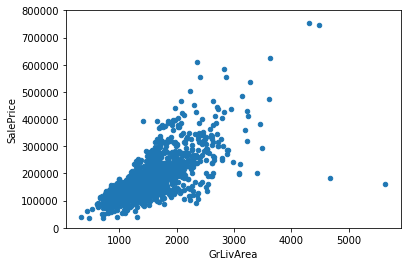

In [171]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

In [172]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,63887,Pave,IR3,Bnk,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Ex,TA,PConc,5644.0,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,1,3,1,Ex,12,3,2.0,1418.0,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,40094,Pave,IR1,Bnk,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Ex,TA,PConc,2260.0,0.0,878.0,3138.0,GasA,Ex,Y,SBrkr,3138,1538,0,4676,3,1,3,1,Ex,11,1,3.0,884.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750


In [173]:
df_train = df_train.drop(df_train[df_train['Id']==1299].index)
df_train = df_train.drop(df_train[df_train['Id']==524].index)

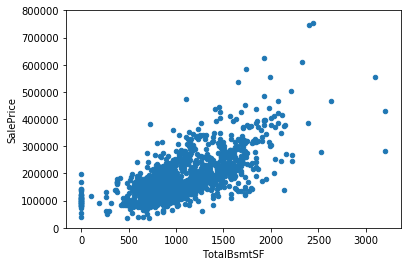

In [174]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

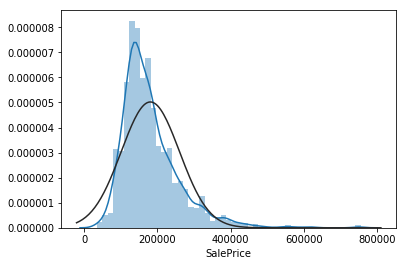

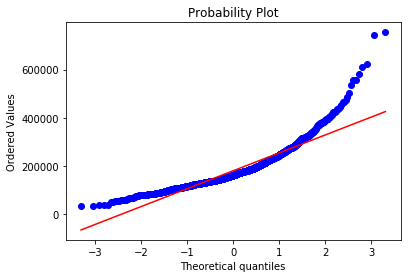

In [175]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [176]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

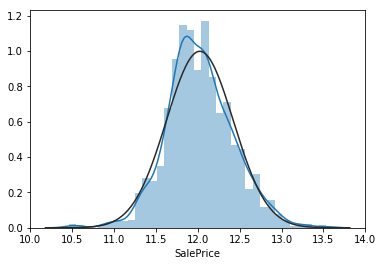

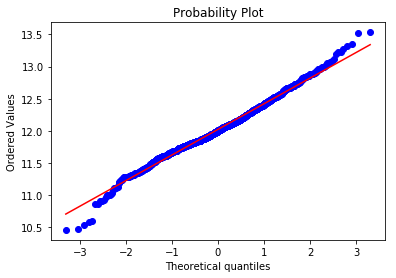

In [177]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

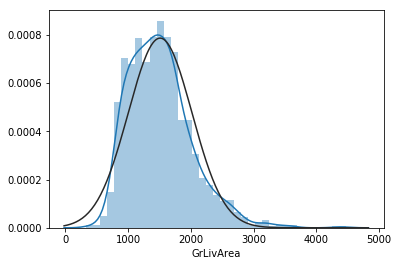

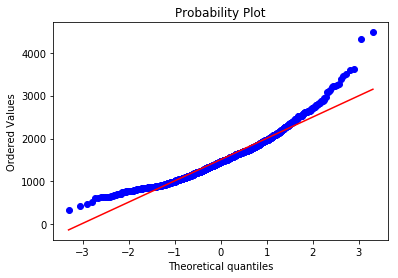

In [178]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [179]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

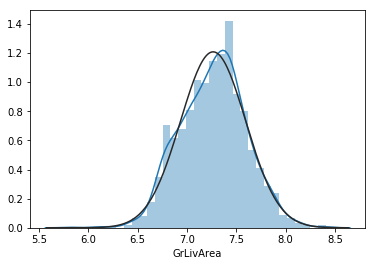

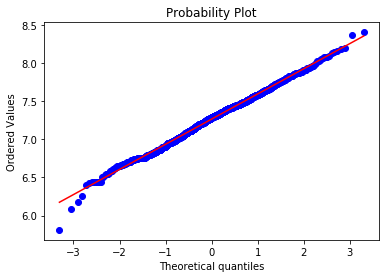

In [180]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

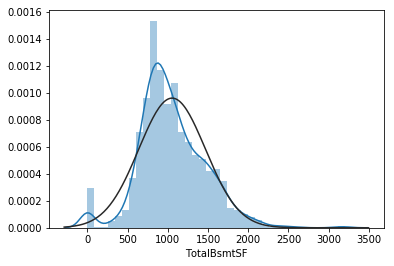

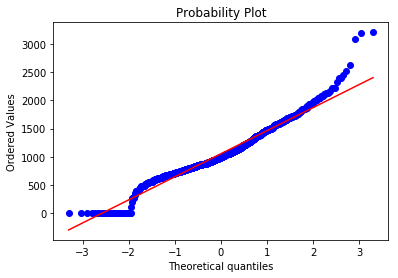

In [181]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

In [182]:
df_train.head()

,Id,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706.0,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,7.444249,2,1,3,1,Gd,8,0,2.0,548.0,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,12.247694
1,2,20,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978.0,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,7.140453,2,0,3,1,TA,6,1,2.0,460.0,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,12.109011
2,3,60,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486.0,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,7.487734,2,1,3,1,Gd,6,1,2.0,608.0,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,12.317167
3,4,70,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216.0,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,7.448334,1,0,3,1,Gd,7,1,3.0,642.0,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,11.849398
4,5,60,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655.0,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,7.695303,2,1,4,1,Gd,9,1,3.0,836.0,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,12.429216


In [183]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_test.index)
df_test['HasBsmt'] = 0 
df_test.loc[df_test['TotalBsmtSF']>0,'HasBsmt'] = 1

In [184]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

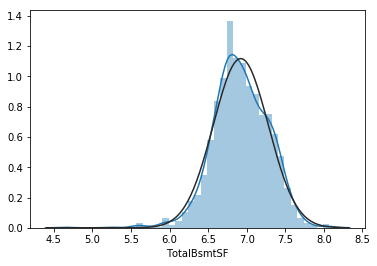

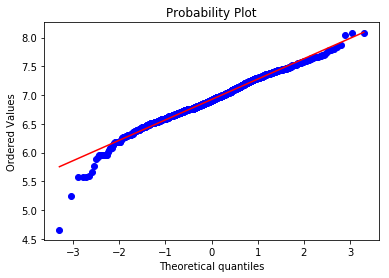

In [185]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

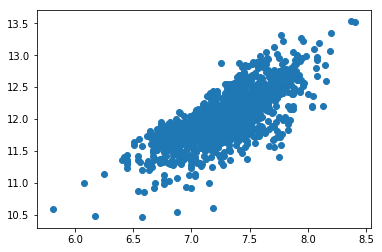

In [186]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

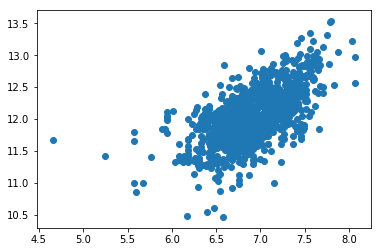

In [187]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

In [188]:
all_data = pd.concat([df_train.drop(['Id','SalePrice'], axis = 1),df_test.drop(['Id'], axis = 1)])

In [189]:
#convert categorical variable into dummy
all_data = pd.get_dummies(all_data)

In [190]:
df_train_tmp = pd.concat([df_train['Id'],all_data[:df_train.shape[0]]], axis=1)
df_train = pd.concat([df_train_tmp,df_train['SalePrice']], axis=1)

In [191]:
df_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,HasBsmt,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,...,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,8450,7,5,2003,2003,706.0,0.0,150.0,6.752270,856,854,0,7.444249,2,1,3,1,8,0,2.0,548.0,0,61,0,0,0,0,0,2,2008,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,12.247694
1,2,20,9600,6,8,1976,1976,978.0,0.0,284.0,7.140453,1262,0,0,7.140453,2,0,3,1,6,1,2.0,460.0,298,0,0,0,0,0,0,5,2007,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,

In [192]:
df_test = pd.concat([df_test['Id'],all_data[df_train.shape[0]:]], axis=1)

In [193]:
X_train = df_train.loc[:, 'MSSubClass':'SaleCondition_Partial']
X_test = df_test.loc[:, 'MSSubClass':'SaleCondition_Partial']
y_train = df_train['SalePrice']

In [194]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [195]:
model_ridge = Ridge()

In [196]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

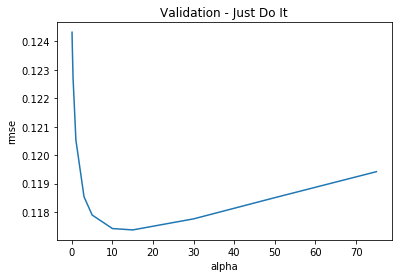

In [197]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [198]:
cv_ridge.min()

0.11737362766369012

In [199]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.000425, 0.000422, 0.000423]).fit(X_train, y_train)

In [200]:
rmse_cv(model_lasso).mean()

0.11671193898465751

In [201]:
rmse_cv(model_lasso)

array([0.11276631, 0.12653513, 0.12492556, 0.10727107, 0.11206163])

In [202]:
model_lasso.alpha_

0.000423

In [203]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [204]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 91 variables and eliminated the other 113 variables


In [205]:
np.abs(coef).sort_values(ascending=False)

Neighborhood_Crawfor     1.071936e-01
GrLivArea                1.030218e-01
Neighborhood_IDOTRR      8.916293e-02
Neighborhood_MeadowV     8.530629e-02
Neighborhood_StoneBr     7.891993e-02
BldgType_Twnhs           6.970140e-02
OverallQual              5.851071e-02
KitchenQual_Ex           5.614144e-02
SaleType_New             5.582116e-02
Neighborhood_OldTown     5.253726e-02
Neighborhood_NridgHt     5.230404e-02
SaleCondition_Abnorml    5.227209e-02
CentralAir_N             4.912499e-02
Exterior1st_BrkFace      4.775600e-02
OverallCond              4.746364e-02
Heating_Grav             4.076105e-02
Condition1_RRAe          3.695862e-02
Neighborhood_Somerst     3.666715e-02
Condition1_Norm          3.613248e-02
Foundation_PConc         3.321139e-02
SaleCondition_Normal     3.124370e-02
LotConfig_CulDSac        3.041908e-02
KitchenAbvGr             3.036785e-02
GarageCars               3.020157e-02
SaleType_WD              2.701097e-02
Neighborhood_BrDale      2.609830e-02
Neighborhood

In [206]:
dropf = coef.loc[np.abs(coef)<1.0e-04].index

In [207]:
dropf = coef.loc[coef==0].index
print(dropf)

Index(['LotArea', 'LowQualFinSF', 'GarageArea', 'MiscVal', 'HasBsmt',
       'Street_Pave', 'LotShape_IR1', 'LotShape_IR3', 'LandContour_Bnk',
       'LandContour_Low',
       ...
       'PavedDrive_Y', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Partial'],
      dtype='object', length=118)


In [208]:
X_train = X_train.drop(dropf, axis = 1)
X_test = X_test.drop(dropf, axis = 1)

In [209]:
X_train.head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,Street_Grvl,LotShape_IR2,LotShape_Reg,LandContour_HLS,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,LandSlope_Sev,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Artery,Condition1_Norm,Condition1_RRAe,BldgType_1Fam,BldgType_2fmCon,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,Exterior1st_BrkFace,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,ExterQual_Ex,ExterCond_TA,Foundation_BrkTil,Foundation_PConc,Heating_Grav,HeatingQC_Ex,HeatingQC_TA,CentralAir_N,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_TA,PavedDrive_N,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal
0,60,7,5,2003,2003,706.0,0.0,150.0,6.752270,856,854,7.444249,2,1,3,1,8,0,2.0,0,61,0,0,0,0,2,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1
1,20,6,8,1976,1976,978.0,0.0,284.0,7.140453,1262,0,7.140453,2,0,3,1,6,1,2.0,298,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1
2,60,7,5,2001,2002,486.0,0.0,434.0,6.824374,920,866,7.487734,2,1,3,1,6,1,2.0,0,42,0,0,0,0,9,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1
3,70,7,5,1915,1970,216.0,0.0,540.0,6.628041,961,756,7.448334,1,0,3,1,7,1,3.0,0,35,272,0,0,0,2,2006,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
4,60,8,5,2000,2000,655.0,0.0,490.0,7.043160,1145,1053,7.695303,2,1,4,1,9,1,3.0,192,84,0,0,0,0,12,2008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1


In [210]:
X_train.shape

(1458, 86)

In [211]:
X_train_original = X_train
X_test_original = X_test

In [212]:
#Scaling data
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [213]:
#from sklearn.decomposition import PCA
#
#pca = PCA(n_components = 180)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

In [214]:
#X_train = pd.DataFrame(X_train)
#X_tets = pd.DataFrame(X_test)

In [215]:
imp_coef = pd.concat([coef.sort_values().head(30),
                     coef.sort_values().tail(30)])

Text(0.5,1,'Coefficients in the Lasso Model')

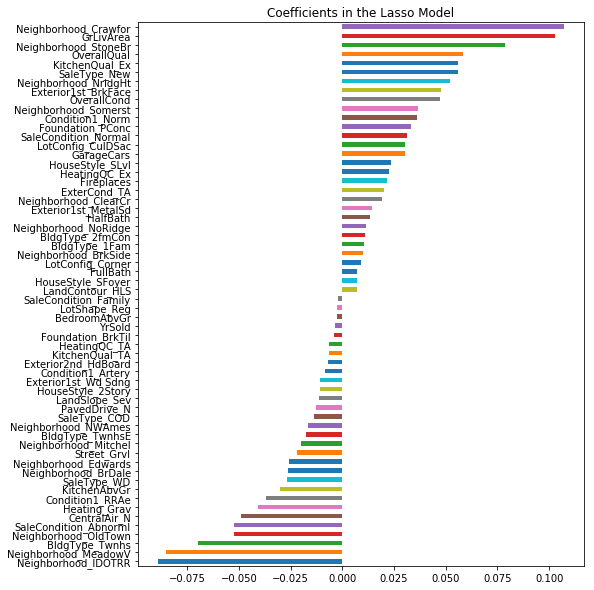

In [216]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [221]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001,0.0002, 0.0003, 0.0005, 0.000173, 0.000172, 0.000171 ]).fit(X_train, y_train)
print(model_lasso.alpha_)
print(rmse_cv(model_lasso).mean())

0.0003
0.11594681251371586


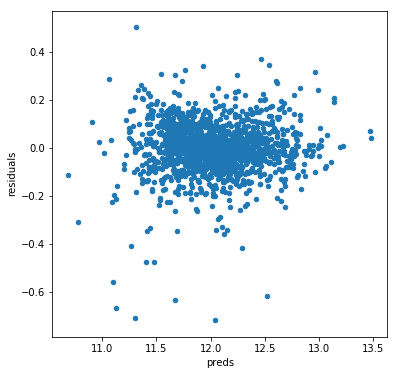

In [218]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [219]:
import xgboost as xgb

In [222]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:47:45] /workspace/sr

[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:45] /workspace/sr

[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/sr

[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/sr

[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/sr

[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/sr

[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:47:46] /workspace/sr

[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/sr

[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/sr

[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/sr

[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/sr

[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:47] /workspace/sr

[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/sr

[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:47:48] /workspace/sr

In [223]:
model.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.380485,0.003503,10.380483,0.008232
1,9.345125,0.003115,9.345122,0.008558
2,8.413374,0.002763,8.413370,0.008844
3,7.574868,0.002481,7.574723,0.008880
4,6.820157,0.002225,6.820022,0.008946


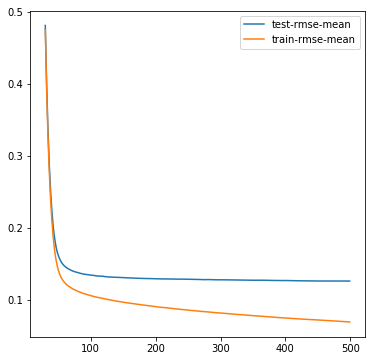

In [224]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [225]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [226]:
rmse_cv(model_xgb).mean()

0.12212530336642764

In [152]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [153]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 8,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(X_train_sc, y_train)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.1350270743924988
{'gamma': 0.0001, 'epsilon': 0.001, 'C': 100}


In [67]:
model_svr = SVR(C=100, epsilon=0.01, gamma=0.0001)
model_svr.fit(X_train_sc, y_train)
#rmse_cv(model_svr).mean()

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [68]:
xgb_preds = np.exp(model_xgb.predict(X_test))
lasso_preds = np.exp(model_lasso.predict(X_test))
svr_preds = np.exp(model_svr.predict(X_test_sc))

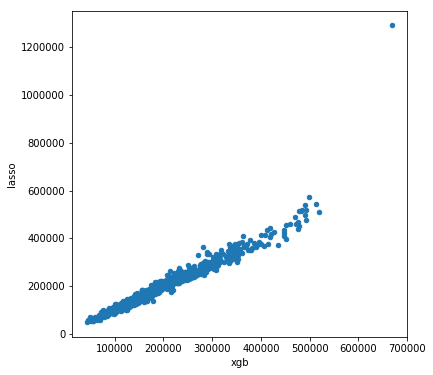

In [69]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

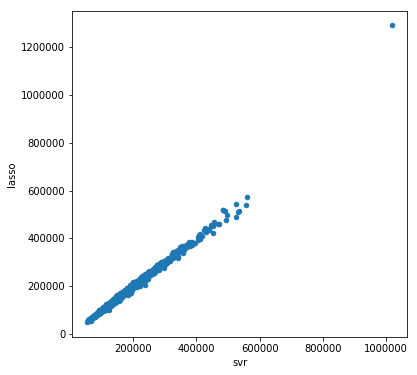

In [70]:
predictions = pd.DataFrame({"svr":svr_preds, "lasso":lasso_preds})
predictions.plot(x = "svr", y = "lasso", kind = "scatter")

In [106]:
#preds = 0.4*lasso_preds + 0.3*xgb_preds + 0.3*svr_preds
#solution = pd.DataFrame({"id":df_test['Id'], "SalePrice":preds})
#solution.to_csv("submission_13.csv", index = False)

In [107]:
preds = 0.3*lasso_preds + 0.2*xgb_preds + 0.5*svr_preds
solution = pd.DataFrame({"id":df_test['Id'], "SalePrice":preds})
#solution.to_csv("submission_14.csv", index = False)

In [108]:
#preds = 0.0*lasso_preds + 0.0*xgb_preds + 1.0*svr_preds
#solution = pd.DataFrame({"id":df_test['Id'], "SalePrice":preds})
#solution.to_csv("submission_15.csv", index = False)

In [109]:
#preds = 0.25*lasso_preds + 0.15*xgb_preds + 0.6*svr_preds
#solution = pd.DataFrame({"id":df_test['Id'], "SalePrice":preds})
#solution.to_csv("submission_16.csv", index = False)